# User and trip characteristics that help predict bike-share trip duration
## by Bilal Karim

## Investigation Overview
In this investigation, I wanted to identify the best predictors of trip duration characteristics of bikeshare trips. Potential use cases for this information include decisions related to marketing strategy, pricing, and capacity planning.

I explored and derived features from individual Ford GoBike bikeshare trips in San Francisco to conclude that the date/time of the trip, specific user characteristics, and whether or not the trip involved a transit station (as either the start or destination) were helpful in predicting trip duration.


## Dataset Overview
### Description
The provided dataset contains information about rides taken in February 2019 using the Ford GoBike bikeshare service. 
The features for each ride provided are origin and destination stations, bike and user info (non-PII), and whether or not the bikeshare service was used for the entirety of the trip. 

### Transformations
The original CSV provided contained 183,412 records, from which I removed 13,278 records due to possible data entry errors or missing relevant information. This left 170,134 records for the analysis.

I also engineered features for whether or not a trip involved a transit station (as either the origin or destination), user age, and trip start day.

In [1]:
# import all packages, set plots to be embedded inline, and set base color for visualizations
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb

%matplotlib inline

# suppress warnings from final output
import warnings
warnings.simplefilter("ignore")

# Setting the base color
base_color = sb.color_palette()[0]

In [2]:
# load in the dataset into a pandas dataframe
df = pd.read_csv('201902-fordgobike-tripdata.csv')

In [3]:
# Necessary data wrangling steps
# Convert datetime columns to appropriate format
df['end_time'] = pd.to_datetime(df['end_time'])
df['start_time'] = pd.to_datetime(df['start_time'])

# Convert bike_share_for_all_trip and user type and gender columns to categorical and boolean formats
df['user_type'] = df['user_type'].astype('category')
df['bike_share_for_all_trip'] = df['bike_share_for_all_trip'] == 'Yes'

# Create a column to denote whether trip was to or from a mass transit station
df['transit_station_trip'] = (df['start_station_name']+df['end_station_name']).str.contains('BART|Caltrain', regex=True)


# Creating columns for the day of week and hour of day
df['trip_start_day'] = df['start_time'].dt.day_name()
df['trip_start_hour'] = df['start_time'].dt.hour

# Converting trip_start_day into an ordered categorical type column
days_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
ordered_days = pd.api.types.CategoricalDtype(ordered=True, categories=days_order)
df['trip_start_day'] = df['trip_start_day'].astype(ordered_days)

# Creating a column containing time-of-day categories for segmented hourly data
bins = [0, 5, 11, 16, 19, 23]
groups = ['late_night', 'morning', 'afternoon', 'evening', 'night']
df['timeofday'] = pd.cut(df['trip_start_hour'], bins, labels = groups, include_lowest=True)
# Converting time-of-day column to an ordered categorical type
dayoftime_order = ['morning', 'afternoon', 'evening', 'night', 'late_night']
ordered_daytime = pd.api.types.CategoricalDtype(ordered=True, categories=dayoftime_order)
df['timeofday'] = df['timeofday'].astype(ordered_daytime)

# Removing 'Other' gender data
df = df[df['member_gender'] != 'Other']

df['user_age'] = df['start_time'].dt.year - df['member_birth_year']
df = df[df['user_age'] <= 66]

In [4]:
# Replace boolean values with 'Yes' and 'No' for legend
df['transit_station_trip'].replace({True: 'Yes', False: 'No'}, inplace=True)

In [5]:
# Creating log transformation function and log-transformed trip duration column
def log_trans(x, inverse = False):
    """ function to compute log and power operations """
    if not inverse:
        return np.log10(x)
    else:
        return np.power(10, x)
    
df['duration_sec_log'] = df['duration_sec'].apply(log_trans)

In [6]:
# Continued data wrangling for user age column
df['member_birth_year'] = df['member_birth_year'].astype(int)
df['user_age'] = df['user_age'].astype(int)

In [7]:
# Removing null station IDs
df = df[df['start_station_id'].notnull()]
df.reset_index(drop=True,inplace=True)

In [8]:
# Dropping unused columns
columns_to_drop = ['start_station_id', 'start_station_latitude','start_station_longitude',
                   'end_station_id', 'end_station_latitude','end_station_longitude',
                   'bike_id','member_birth_year']
df.drop(columns=df[columns_to_drop], inplace=True)

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 170134 entries, 0 to 170133
Data columns (total 14 columns):
 #   Column                   Non-Null Count   Dtype         
---  ------                   --------------   -----         
 0   duration_sec             170134 non-null  int64         
 1   start_time               170134 non-null  datetime64[ns]
 2   end_time                 170134 non-null  datetime64[ns]
 3   start_station_name       170134 non-null  object        
 4   end_station_name         170134 non-null  object        
 5   user_type                170134 non-null  category      
 6   member_gender            170134 non-null  object        
 7   bike_share_for_all_trip  170134 non-null  bool          
 8   transit_station_trip     170134 non-null  object        
 9   trip_start_day           170134 non-null  category      
 10  trip_start_hour          170134 non-null  int64         
 11  timeofday                170134 non-null  category      
 12  user_age        

# Distribution of trip duration

Trip duration took on a large range of values in the given data: from 61 seconds (around 1 minute) to 84548 seconds (around 23.5 hours).

Plotted on a logarithmic scale, the distribution looks normal, with a peak at around 550 seconds (Approximately 10 minutes).

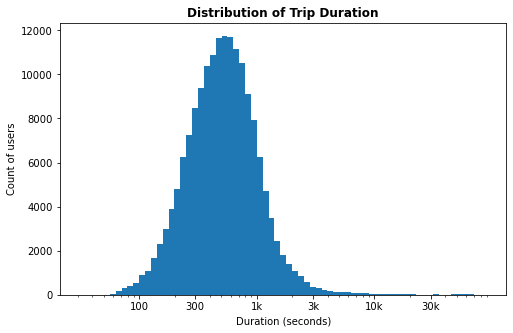

In [10]:
log_binsize = 0.05
bins = 10 ** np.arange(1.5, np.log10(df['duration_sec'].max())+log_binsize, log_binsize)
ticks = [100, 300, 1000, 3000, 10000, 30000]
labels = [100, 300, '1k', '3k', '10k', '30k']
plt.figure(figsize=[8, 5])
plt.hist(data = df, x = 'duration_sec', bins = bins)
plt.title('Distribution of Trip Duration', weight='bold')
plt.xscale('log')
plt.xticks(ticks, labels)
plt.xlabel('Duration (seconds)')
plt.ylabel('Count of users')
plt.show()

## An overview of the service's user base
The mix of users in the data leans heavily towards subscribers vs. customers. 'Subscribers' are defined as users who pay an ongoing subscription fee to use the bike share service, whereas 'Customers' are ad hoc users.

The data also contains more than three times as many males than females.

The age range of users is between 18 and 66 years, after removing outliers. On a histogram with bin sizes of 1 year, the age variable shows a slightly positive skew, with two notable modes: 31 and 26 years.

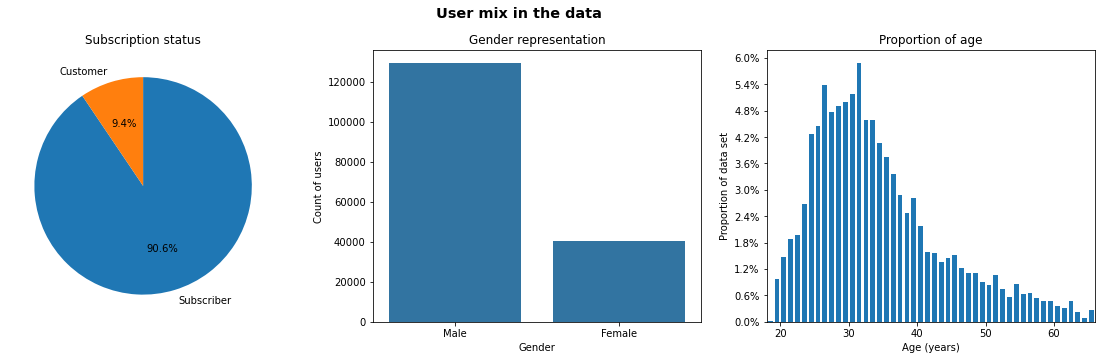

In [11]:
# plt.figure(figsize = [20,4])
fig, axes = plt.subplots(1,3, figsize = [20,5])
fig.suptitle('User mix in the data', size='x-large', weight='bold', y=1.0)

plt.subplot(1, 3, 1)
sorted_counts = df['user_type'].value_counts(1)
plt.pie(sorted_counts, labels = sorted_counts.index, autopct = '%1.1f%%', startangle = 90, counterclock = False)
plt.title('Subscription status')

plt.subplot(1, 3, 2)
sb.countplot(data=df, x='member_gender', color=base_color)
plt.xlabel('Gender')
plt.ylabel('Count of users')
plt.title('Gender representation')

plt.subplot(1, 3, 3)
#Setting bin size to 1 year per bar
binsize = 1
bins = np.arange(0, df['user_age'].max()+binsize, binsize)
# Getting user age proportions to change y axis ticks to relative frequency
users_counts = df['user_age'].value_counts()
users_order = users_counts.index
n_users = users_counts.sum()
max_prop =  users_counts.max()/n_users
tick_props = np.arange(0, max_prop+0.006, 0.006)
tick_names = ['{:0.1f}%'.format(v*100) for v in tick_props]
# plt.figure(figsize=[8, 5])
plt.hist(data = df, x = 'user_age', bins = bins, rwidth=0.7)
plt.xlabel('Age (years)')
plt.xlim(df['user_age'].min(),df['user_age'].max())
plt.yticks(tick_props * n_users,tick_names)
plt.ylabel('Proportion of data set')
plt.title('Proportion of age')
plt.show()

## Average trip duration by day of week and time of day

By far, the best predictors of trip duration in the data set were date and time variables.

Average trip duration is around 850 seconds on the weekends, whereas it is between 650 and 700 seconds on weekdays. It is also usually higher in afternoons than at other times of the day, especially between Thursday and Monday, when tourists may be in town, using the bike share service for leisure trips.

Here, I have plotted log-transformed average trip duration by time of day and day of week to showcase this.

''

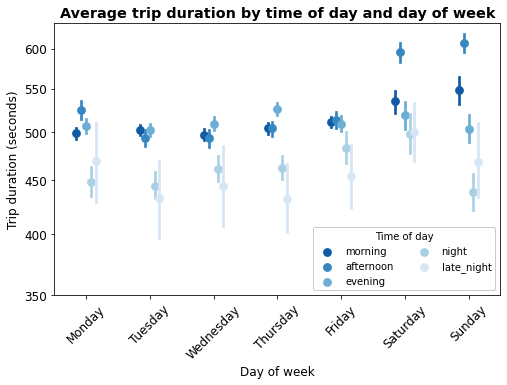

In [12]:
plt.figure(figsize=[8, 5])
ticks = [350, 400, 450, 500, 550, 600]
labels = ['{}'.format(v) for v in ticks]
bar = sb.pointplot(data = df, x = 'trip_start_day', y = 'duration_sec_log', hue = 'timeofday', dodge=0.3, linestyles = "", palette = 'Blues_r')
bar.legend(loc = 'lower right', ncol = 2, framealpha = 1, title = 'Time of day')
plt.ylabel('Trip duration (seconds)', size='large')
plt.xlabel('Day of week', size='large')
plt.yticks(log_trans(ticks), labels, size='large')
plt.xticks(size='large', rotation=45)
plt.title('Average trip duration by time of day and day of week', size='x-large', weight='bold')
;

## Trip duration by user type and gender

Average trip duration is higher for users who subscribe to the service than for customers, and for females than for males.

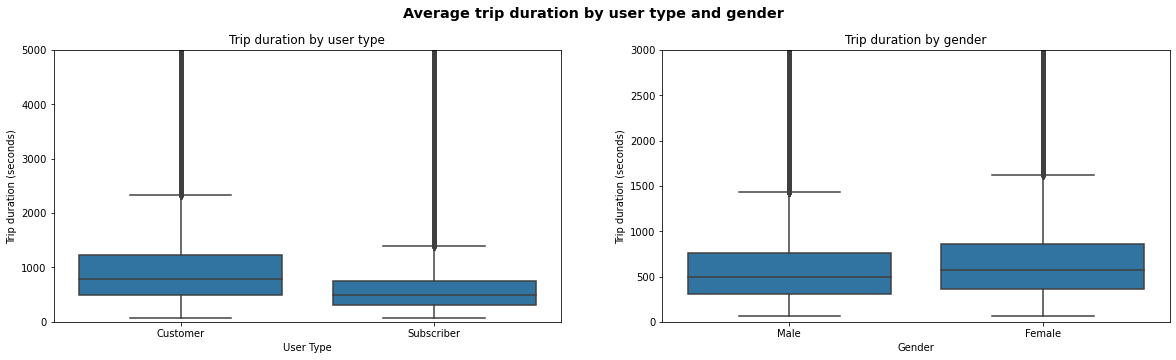

In [13]:
fig, axes = plt.subplots(1,2, figsize = [20,5])
fig.suptitle('Average trip duration by user type and gender', size='x-large', weight='bold', y=1.0)

plt.subplot(1, 2, 1)
# Box plot comparing trip duration by user type
sb.boxplot(data = df, x = 'user_type', y = 'duration_sec', color = base_color)
plt.title('Trip duration by user type')
plt.ylabel('Trip duration (seconds)')
plt.xlabel('User Type')
plt.ylim(0,5000);

plt.subplot(1, 2, 2)
# Box plot comparing trip duration by gender
sb.boxplot(data = df, x = 'member_gender', y = 'duration_sec', color = base_color)
plt.title('Trip duration by gender')
plt.xlabel('Gender')
plt.ylabel('Trip duration (seconds)')
plt.ylim(0,3000);

## Another strong predictor of trip duration was whether or not the trip involved a transit station
As the trip starting and destination stations were provided in the data, I derived a feature to indicate whether the trip was to or from a transit station. 

It turned out that this feature was a strong predictor of trip duration - trips to or from a transit station were shorter than those that did not involve a transit station. This effect is likely caused as users may use these bikes for leisure trips or to commute to and from their work rather than to a transit station.

I have plotted this variable by day of week below.

''

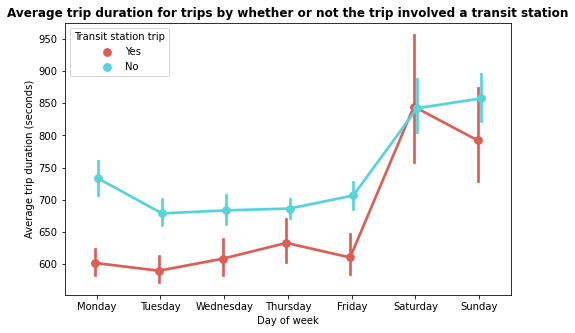

In [14]:
plt.figure(figsize=[8, 5])
sb.pointplot(data = df, x = 'trip_start_day', y = 'duration_sec', hue = 'transit_station_trip', palette = 'hls',
                  dodge = True)
plt.xlabel('Day of week')
plt.ylabel('Average trip duration (seconds)')
plt.legend(title='Transit station trip')
plt.title('Average trip duration for trips by whether or not the trip involved a transit station', size='large',weight='bold')
;

## An interesting finding about the correlation of user age with trip duration
Upon intial exploration, user age and trip duration seemed to be negatively correlated. Upon inspection alongside the day of week variable, I found that the difference in trip duration between weekdays and weekends gets larger for users older than 35 years and up to 60 years of age (even though weekend trips are longer across all user ages). At that point, the difference between weekday and weekend trip duration seems to be negligible, if at all present.

This suggests a pattern of older users visiting the Bay Area for either leisure or business throughout the week and using the bike share service at about the same throughout the week.

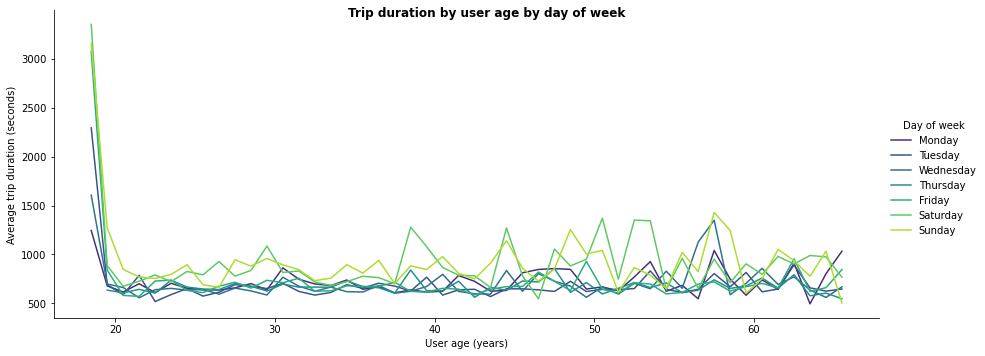

In [15]:
def mean_poly(x, y, bins = 10, **kwargs):
    """ Custom adapted line plot code. """
    # set bin edges if none or int specified
    if type(bins) == int:
        bins = np.linspace(x.min(), x.max(), bins+1)
    bin_centers = (bin_edges[1:] + bin_edges[:-1]) / 2

    # compute counts
    data_bins = pd.cut(x, bins, right = False,
                       include_lowest = True)
    means = y.groupby(data_bins).mean()

    # create plot
    plt.errorbar(x = bin_centers, y = means, **kwargs)

bin_edges = np.arange(18, df['user_age'].max()+1, 1)
g = sb.FacetGrid(data = df, hue = 'trip_start_day', height = 5, aspect = 20/8, palette='viridis')
g.map(mean_poly, "user_age", "duration_sec", bins = bin_edges)
g.set_ylabels('Average trip duration (seconds)')
g.set_xlabels('User age (years)')
g.fig.suptitle('Trip duration by user age by day of week', weight='bold')
g.add_legend(title='Day of week');